### Inverting Synthetic data for dykes 
- Synthetic grvaity data will be generated for dykes and the random noise will be added.
- The synthetic data will be inverted for the dyke parameters

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
from tabulate import tabulate

In [2]:
def gravity_anomaly_dyke(x,top_depth,beta,bottom_depth,width,density_contrast):
    G = 6.67430e-11  # gravitational constant in m^3 kg^-1 s^-2
    rho_m = density_contrast  # density contrast
    beta = beta*np.pi/180 # degree to radians
    B=width # Width of the dyke
    #print(B)
    z1=top_depth 
    z2=bottom_depth
    theta1=np.arctan(x/z1+np.tan(beta))
    theta2=np.arctan(x/z2+np.tan(beta))
    theta3=np.arctan((x-B)/z1+np.tan(beta))
    theta4=np.arctan((x-B)/z2+np.tan(beta))
    #print(theta1)
    #print(theta2)
    psi1 = np.abs(theta1-beta)
    psi2 = np.abs(theta2-beta)
    psi3 = np.abs(theta3-beta)
    psi4 = np.abs(theta4-beta)
    F1=psi1*(1.0/np.tan(psi1))-np.log(np.sin(psi1))
    F2=psi2*(1.0/np.tan(psi2))-np.log(np.sin(psi2))
    F3=psi3*(1.0/np.tan(psi3))-np.log(np.sin(psi3))
    F4=psi4*(1.0/np.tan(psi4))-np.log(np.sin(psi4))
    gravity_anomaly = 2.0*G*rho_m*(np.cos(beta)*np.cos(beta)*(x*(F2-F1)-(x-B)*(F4-F3)))
    dyke_shape_x = np.array([-np.tan(beta)*z1,-np.tan(beta)*z1+B,-np.tan(beta)*z2+B,-np.tan(beta)*z2,-np.tan(beta)*z1])
    dyke_shape_z = np.array([-z1,-z1,-z2,-z2,-z1])
    
    return (gravity_anomaly,dyke_shape_x,dyke_shape_z)

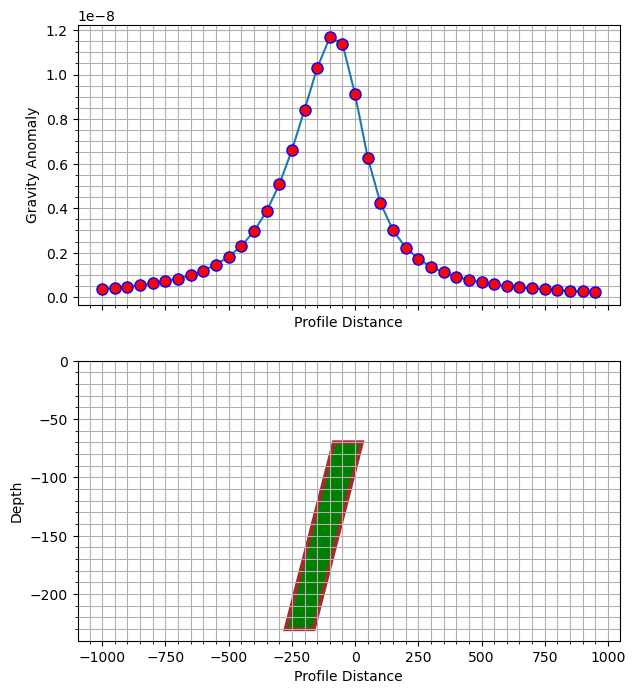

In [3]:
x=np.arange(-1000,1000,50)+0.00001 # adding the value because the formula breaks at x=0
beta=50
top_depth=70
bottom_depth=230
width=110
density_contrast=.8
(g,dyke_shape_x,dyke_shape_z) = gravity_anomaly_dyke(x,top_depth,beta,bottom_depth,width,density_contrast)
fig,(ax1,ax2) = plt.subplots(2,1,sharex=True)
ax1.plot(x,g,marker='o', mfc='red', mec='blue',ms='8')
ax2.fill(dyke_shape_x,dyke_shape_z,facecolor='green', edgecolor='brown', linewidth=3)
ax2.set_ylim(-bottom_depth-10,0)
ax1.grid(which='both')
ax2.grid(which='both')
ax1.set_xlabel("Profile Distance")
ax2.set_xlabel("Profile Distance")
ax1.set_ylabel("Gravity Anomaly")
ax2.set_ylabel("Depth")
ax1.minorticks_on()
ax2.minorticks_on()
fig.set_size_inches(7,8)

In [4]:
# Adding noise to the gravity data
noise_percent=0/100 # percentage of noise to be added
g_noise=g+g.max()*np.random.random(g.shape)*noise_percent

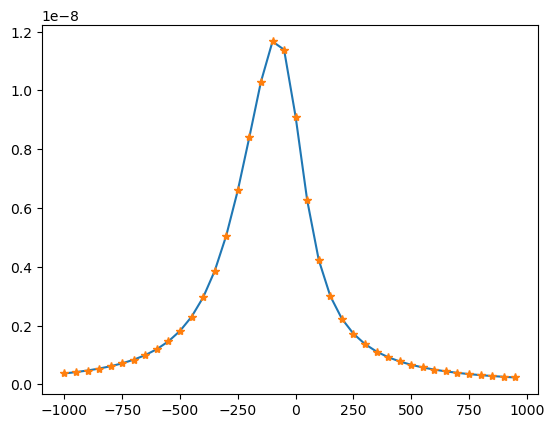

In [5]:
plt.plot(x,g)
plt.plot(x,g_noise,'*')

In [6]:
# Inverting the Noisy data using PSO

In [7]:

# Define the fitness function to be optimized
def fitness_function(x):
    # Calculate the fitness value for a given particle position
    # This can be replaced with any other function based on the problem being solved
    dim = len(x)
    return NonlinearFunctions.sphere(x, dim)

class Particle:
    def __init__(self, min_x,max_x,dim,grp_id):
        # Initialize the particle with a random position and velocity
        self.min_x=min_x
        self.max_x=max_x
        self.dim = dim
        self.position = np.random.uniform(low=min_x, high=max_x, size=dim)
        self.velocity = np.random.uniform(low=min_x, high=max_x, size=dim)
        
        self.best_position = self.position.copy()
        self.best_fitness = fitness_function(self.position)
        
        self.group_id = grp_id

    def update_velocity(self, global_best_position, inertia_weight, cognitive_weight, social_weight):
        # Update the velocity of the particle based on the PSO equation
        #print(global_best_position)
        
        for d in range(self.dim):
            self.velocity[d] = (inertia_weight[self.group_id] * self.velocity[d]) + (cognitive_weight[self.group_id] * np.random.rand() * 
            (self.best_position[d] - self.position[d])) + (social_weight[self.group_id] * np.random.rand() * 
            (global_best_position[d] - self.position[d]))
        #print(self.velocity)
        
    def update_coefficients(self, t, T):
        w = [.7,.7,.7,.7]#[.9 + (((T-t))/T) * -.4,.9 + (((T-t))/T) * -.4,.9 + (((T-t))/T) * -.4,.9 + (((T-t))/T) * -.4]
        
        c1 = [1.95 - (2.0*t**(1/3))/(T**(1/3)),-(2.0*t**3)/T**3 + 2.5,
              1.95 - (2.0*t**(1/3))/(T**(1/3)),-(2.0*t**3)/T**3 + 2.5]
        c2 = [(2.0*t**(1/3))/(T**(1/3)) + 0.05,(2.0*t**3)/T**3 + 0.05,
              (2.0*t**3)/T**3 + 0.05,(2.0*t**(1/3))/(T**(1/3)) + 0.05]
        return w,c1,c2
            
            
    
    def clip_position(self):
        for j in range(self.dim):
            if self.position[j] < self.min_x:
                self.position[j]= self.min_x
            if self.position[j] > self.max_x:
                self.position[j]= self.max_x
    
    def update_position(self):
        # Update the position of the particle based on its velocity
        self.position = self.position + self.velocity
        self.clip_position()
        
    def evaluate_fitness(self):
        # Evaluate the fitness of the particle and update its best position if necessary
        fitness = fitness_function(self.position)
        if fitness < self.best_fitness:
            self.best_position = self.position.copy()
            self.best_fitness = fitness
    
    def update_coefficients2(self, t, T):
        w = [.5*((T-t))/T+.4]
        return w
        
def assign_dynamic_group(swarm,Ngrp):
    fitness_array=[]
    for particle in swarm:
        fitness_array.append(particle.best_fitness)
    fitness_array = np.array(fitness_array)
    fitness_sord_id = np.argsort(fitness_array)
    for i in range(fitness_sord_id.size):
        swarm[fitness_sord_id[i]].group_id = i%Ngrp
#all groups will have a similar range of fitnesses. 
    


def particle_swarm_optimization(dim, min_x,max_x,inc_x,num_particles, num_iterations, inertia_weight, 
                                cognitive_weight, social_weight,pso_type=0,
                                isplot=True,plot_every=4):
    """pso_type=0-Vanilla PSO,pso_type=1, static group pso,pso_type=2,dynamic group pso"""
    # Initialize the swarm with random particles
    Ngrp = len(inertia_weight)
    if pso_type==0:
        swarm = [Particle(min_x,max_x,dim,0) for i in range(num_particles)]
    else:
        swarm = [Particle(min_x,max_x,dim,i%Ngrp) for i in range(num_particles)]
    if pso_type==2:
        assign_dynamic_group(swarm,Ngrp)

    # Initialize the global best position and fitness
    global_best_position = None
    global_best_fitness = float('inf')
    for particle in swarm:
        if particle.best_fitness < global_best_fitness:
            global_best_position = particle.best_position.copy()
            global_best_fitness = particle.best_fitness

    
    
    error_list=[]
    # Perform the optimization iterations
    for itrn in range(num_iterations):
        # Update the position and fitness of each particle
        
        for particle in swarm:
            if pso_type ==0:
                    inertia_weight = particle.update_coefficients2(itrn, num_iterations)
            if pso_type ==1 or pso_type ==2:
                inertia_weight, cognitive_weight, social_weight = particle.update_coefficients(itrn, num_iterations)
            particle.update_velocity(global_best_position, inertia_weight, cognitive_weight, social_weight)
            particle.update_position()
            particle.evaluate_fitness()
            # Update the global best position and fitness if necessary
            if particle.best_fitness < global_best_fitness:
                global_best_position = particle.best_position.copy()
                global_best_fitness = particle.best_fitness
        
        error_list.append(global_best_fitness)
        if pso_type==2:
                assign_dynamic_group(swarm,Ngrp)
        
        # Plotting True
        if isplot:
            # for plotting purpose
            x = np.arange(min_x,max_x,inc_x)
            y = np.arange(min_x,max_x,inc_x)
            xv, yv = np.meshgrid(x, y)
            zv = np.zeros((x.size,y.size))
            for i in range(x.size):
                for j in range(y.size):
                    zv[i][j]=fitness_function(np.array([xv[i][j],yv[i][j]]))
            if plot_every != 0 and itrn%plot_every == 0:
                # Create a figure and axis objects
                fig, ax2D = plt.subplots(1, 1, figsize=(10, 8))
                # Plot the filled contour
                contour = ax2D.contourf(xv, yv, zv, cmap='viridis')
                
                color_list=["green","blue","red","purple"] # increase the colorlist if we want to add more groups
                # Plotting the swarms
                for particle in swarm:
                    plt.plot(particle.position[0],particle.position[1],'o',ms=5,mec = 'w',mfc=color_list[particle.group_id])
                    plt.arrow(particle.position[0], particle.position[1], 0.5*particle.velocity[0], 0.5*particle.velocity[1], 
                              width = 0.05)
                
                plt.plot(global_best_position[0],global_best_position[1],'*',ms=10,mec = 'r',mfc='y')
                # Add a colorbar
                cbar = plt.colorbar(contour,ax=ax2D)

                # Add labels and title
                ax2D.set_xlim((min_x,max_x))
                ax2D.set_ylim((min_x,max_x))
                ax2D.set_xlabel('X')
                ax2D.set_ylabel('Y')
                ax2D.set_title('Iteration # '+str(itrn))
                ax2D.set_aspect('equal')

                # Show the plot
                plt.show()


    return global_best_position, global_best_fitness,error_list,pso_type

PSO_TYPES = ["Vanilla","Static-Group","Dynamic-Group"]

### Important
### The Input data is given here

In [8]:
# Important
# The Input data is given here
g_obs = g_noise # simulating the input noisy data
x_stations = x # position of the stations where the gravity data are observed
# Parameter-0 Top depth
min_top_depth = 10
max_top_depth = 300
# Parameter-1 Bottom Depth = Top_depth+length of the body
min_length_of_body = 10
max_length_of_body = 600
#Parameter-2 Dipping angle
min_dipping_angle= 0
max_dipping_angle= 75
#Parameter-3 Width of the body
min_width=10
max_width=300
# Parameter-4 Density contrast
min_density_contrast=.2
max_density_contrast=2

In [9]:
# Define the fitness function to be optimized
def fitness_function(x):
    # Calculate the fitness value for a given particle position
    # The parameters we have to optimize in-case of dyke are follows
    # (0) Top depth 
    # (1) Bottom depth
    # (2) Dipping angle
    # (3) Width
    # (4) Density contrast
    dim = 5
    # computing forward model
    # PSO returns x value from 0 to 1. scaling this value to vary between the minimum and maximum value
    top_depth = min_top_depth+x[0]*(max_top_depth-min_top_depth)
    bottom_depth = top_depth + min_length_of_body+x[1]*(max_length_of_body-min_length_of_body)
    beta = min_dipping_angle+x[2]*(max_dipping_angle-min_dipping_angle)
    width = min_width+x[3]*(max_width-min_width)
    density_contrast = min_density_contrast+x[4]*(max_density_contrast-min_density_contrast)
    (gi,dyke_shape_x,dyke_shape_z) = gravity_anomaly_dyke(x_stations,top_depth,beta,bottom_depth,width,density_contrast)
    # calculating the least square error
    error = np.mean((g_obs-gi)*(g_obs-gi))
    return error


In [10]:

dim = 5  # Dimension of the problem
num_particles = 200  # Number of particles in the swarm
num_iterations = 1500  # Number of iterations
inertia_weight = [0.7,0.7,0.7,0.7]  # Inertia weight
cognitive_weight = [1.95, 2.5, 1.95, 2.5]  # Cognitive weight
social_weight = [0.05,0.05,0.05,0.05]  # Social weight
min_xy=0
max_xy=1.0
inc_xy=0.1 # For plotting purpose only
test_amount = 1
best_pos_array = np.zeros((5,test_amount))
print("running")
start_time = time.time()
best_position = 0
for i in range(test_amount):
    time1 = time.time()
    best_position, best_fitness,error_output_list,pso_type1 = particle_swarm_optimization(dim,min_xy,max_xy,inc_xy,num_particles, num_iterations, 
                                                              inertia_weight,cognitive_weight, social_weight,
                                                              pso_type=2,isplot=False,plot_every=5)
    best_pos_array[0][i] = best_position[0]
    best_pos_array[1][i] = best_position[1]
    best_pos_array[2][i] = best_position[2]
    best_pos_array[3][i] = best_position[3]
    best_pos_array[4][i] = best_position[4]
    
    print(i)
    print(time.time()-time1)




running
0
29.682677030563354


Text(0, 0.5, 'Error')

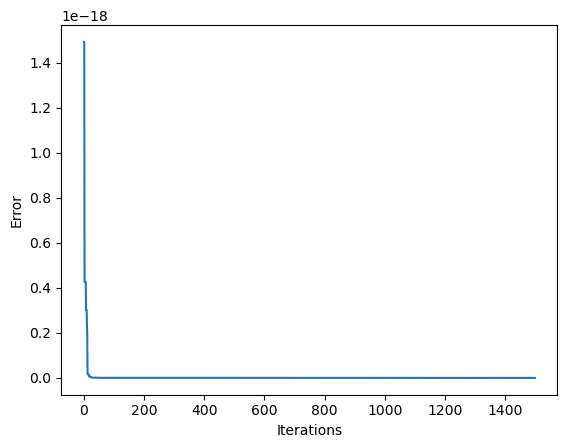

In [11]:
plt.plot(error_output_list)
plt.xlabel("Iterations")
plt.ylabel("Error")

In [12]:
xi=best_pos_array #best_position

In [13]:
# PSO returns x value from 0 to 1. scaling this value to vary between the minimum and maximum value
estimated_top_depth = min_top_depth+xi[0]*(max_top_depth-min_top_depth)
estimated_bottom_depth = top_depth + min_length_of_body+xi[1]*(max_length_of_body-min_length_of_body)
estimated_beta = min_dipping_angle+xi[2]*(max_dipping_angle-min_dipping_angle)
estimated_width = min_width+xi[3]*(max_width-min_width)
estimated_density_contrast = min_density_contrast+xi[4]*(max_density_contrast-min_density_contrast)





#new
std0 = np.std(estimated_top_depth)
std1 = np.std(estimated_bottom_depth)
std2 = np.std(estimated_beta)
std3 = np.std(estimated_width)
std4 = np.std(estimated_density_contrast)

mean0 = np.mean(estimated_top_depth)
mean1 = np.mean(estimated_bottom_depth)
mean2 = np.mean(estimated_beta)
mean3 = np.mean(estimated_width)
mean4 = np.mean(estimated_density_contrast)

med0 = np.median(estimated_top_depth)
med1 = np.median(estimated_bottom_depth)
med2 = np.median(estimated_beta)
med3 = np.median(estimated_width)
med4 = np.median(estimated_density_contrast)

end_time = time.time()
print(end_time-start_time)
table = [["hi","z1","z2","beta", "width", "density"],
        ["Standard Deviation", std0, std1, std2, std3, std4],
         ["Average Best", mean0, mean1, mean2, mean3, mean4,],
         ["Median Best", med0, med1, med2, med3, med4]]
print(tabulate(table))

estimated_top_depth = mean0
estimated_bottom_depth = mean1
estimated_beta = mean2
estimated_width = mean3
estimated_density_contrast = mean4

29.864970922470093
------------------  -----------------  ------------------  ------------------  ------------------  ------------------
hi                  z1                 z2                  beta                width               density
Standard Deviation  0.0                0.0                 0.0                 0.0                 0.0
Average Best        69.99999999158406  230.00000143797337  49.999999697866144  109.99999737206213  0.8000000127759699
Median Best         69.99999999158406  230.00000143797337  49.999999697866144  109.99999737206213  0.8000000127759699
------------------  -----------------  ------------------  ------------------  ------------------  ------------------


In [14]:
# Original assumed parameters
print(top_depth)
print(bottom_depth)
print(beta)
print(width)
print(density_contrast)

70
230
50
110
0.8


In [15]:
# Estimated data parameters
print(estimated_top_depth)
print(estimated_bottom_depth)
print(estimated_beta)
print(estimated_width)
print(estimated_density_contrast)

69.99999999158406
230.00000143797337
49.999999697866144
109.99999737206213
0.8000000127759699


In [16]:
#plotting the fitted curve with the best parameters
(g_estimated,dyke_shape_x_est,dyke_shape_z_est) = gravity_anomaly_dyke(x_stations,estimated_top_depth,
                                                      estimated_beta,estimated_bottom_depth,
                                                      estimated_width,estimated_density_contrast)

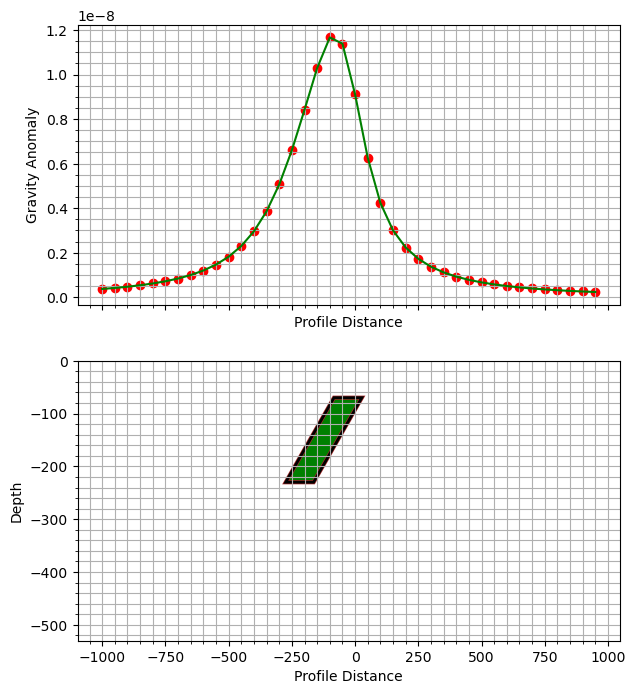

In [17]:
(g_obs,dyke_shape_x,dyke_shape_z) = gravity_anomaly_dyke(x,top_depth,beta,bottom_depth,width,density_contrast)
fig,(ax1,ax2) = plt.subplots(2,1,sharex=True)
ax1.scatter(x,g_obs,marker='o',color='red') # Original data
ax1.plot(x_stations,g_estimated,'-',color='green') # fitted data

ax2.fill(dyke_shape_x,dyke_shape_z,facecolor='green', edgecolor='brown', linewidth=3) # original model
ax2.fill(dyke_shape_x_est,dyke_shape_z_est,facecolor='none',edgecolor='black',linewidth=2) # Estimated model
ax2.set_ylim(-bottom_depth-300,0)
ax1.grid(which='both')
ax2.grid(which='both')
ax1.set_xlabel("Profile Distance")
ax2.set_xlabel("Profile Distance")
ax1.set_ylabel("Gravity Anomaly")
ax2.set_ylabel("Depth")
ax1.minorticks_on()
ax2.minorticks_on()
fig.set_size_inches(7,8)